# Fine Tuning single-cell image extraction

In this notebook we will look at how the specific values chosen to configure the single-cell extraction step will effect the generated single-cell images.

In [ ]:
import os

from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.data._datasets import dataset_7

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Generate segmentation masks for use during single-cell extraction

First we will create our scPortrait project, load the input images and generate a segmentation that we will use for subsequent single-cell extraction.

In [2]:
project_location = "project_extraction_config"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=True,
    debug=False,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

dataset_7_path = dataset_7()
images = [f"{dataset_7_path}/Ch1.tif", f"{dataset_7_path}/Ch2.tif", f"{dataset_7_path }/Ch3.tif", f"{dataset_7_path }/Ch4.tif"]
project.load_input_from_tif_files(images, channel_names=["Hoechst", "Cellmembrane", "marker1", "marker2"])

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/development/project_extraction_config/scportr
         ait.sdata                                                                                                 


The chosen input images are from a dataset where we have two stains with very different behaviour. The first (`marker1`) appears in all cells. For this stain we are mainly interested in differences in spatial distribution of the marker but not absolute expression levels. The second stain (`marker2`) is a selective stain that only appears in some of the cells. Here we are interested in both spatial distribution as well as relative differences in expression levels.

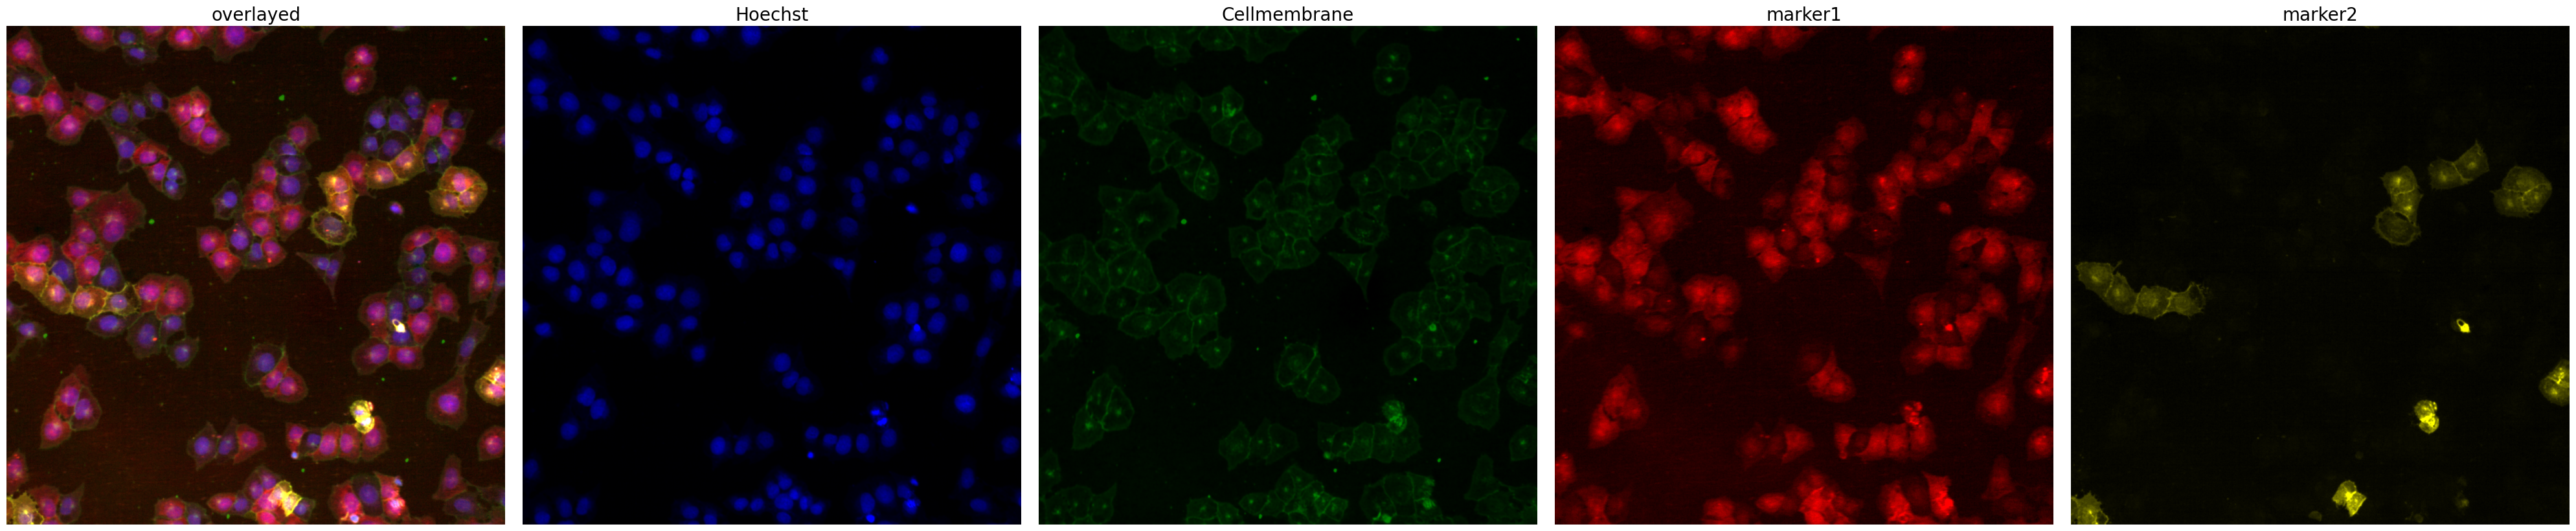

In [3]:
project.plot_input_image()

During Segmentation its important that we use channels that show homogenous expression over all cells. Otherwise we would be introducing bias during the segmentation step already and selecting only specific cells. 

By using scPortrait's `CytosolSegmentationCellpose` we are already only selecting those cells where we have a clear matching between nucleus and cytosol.

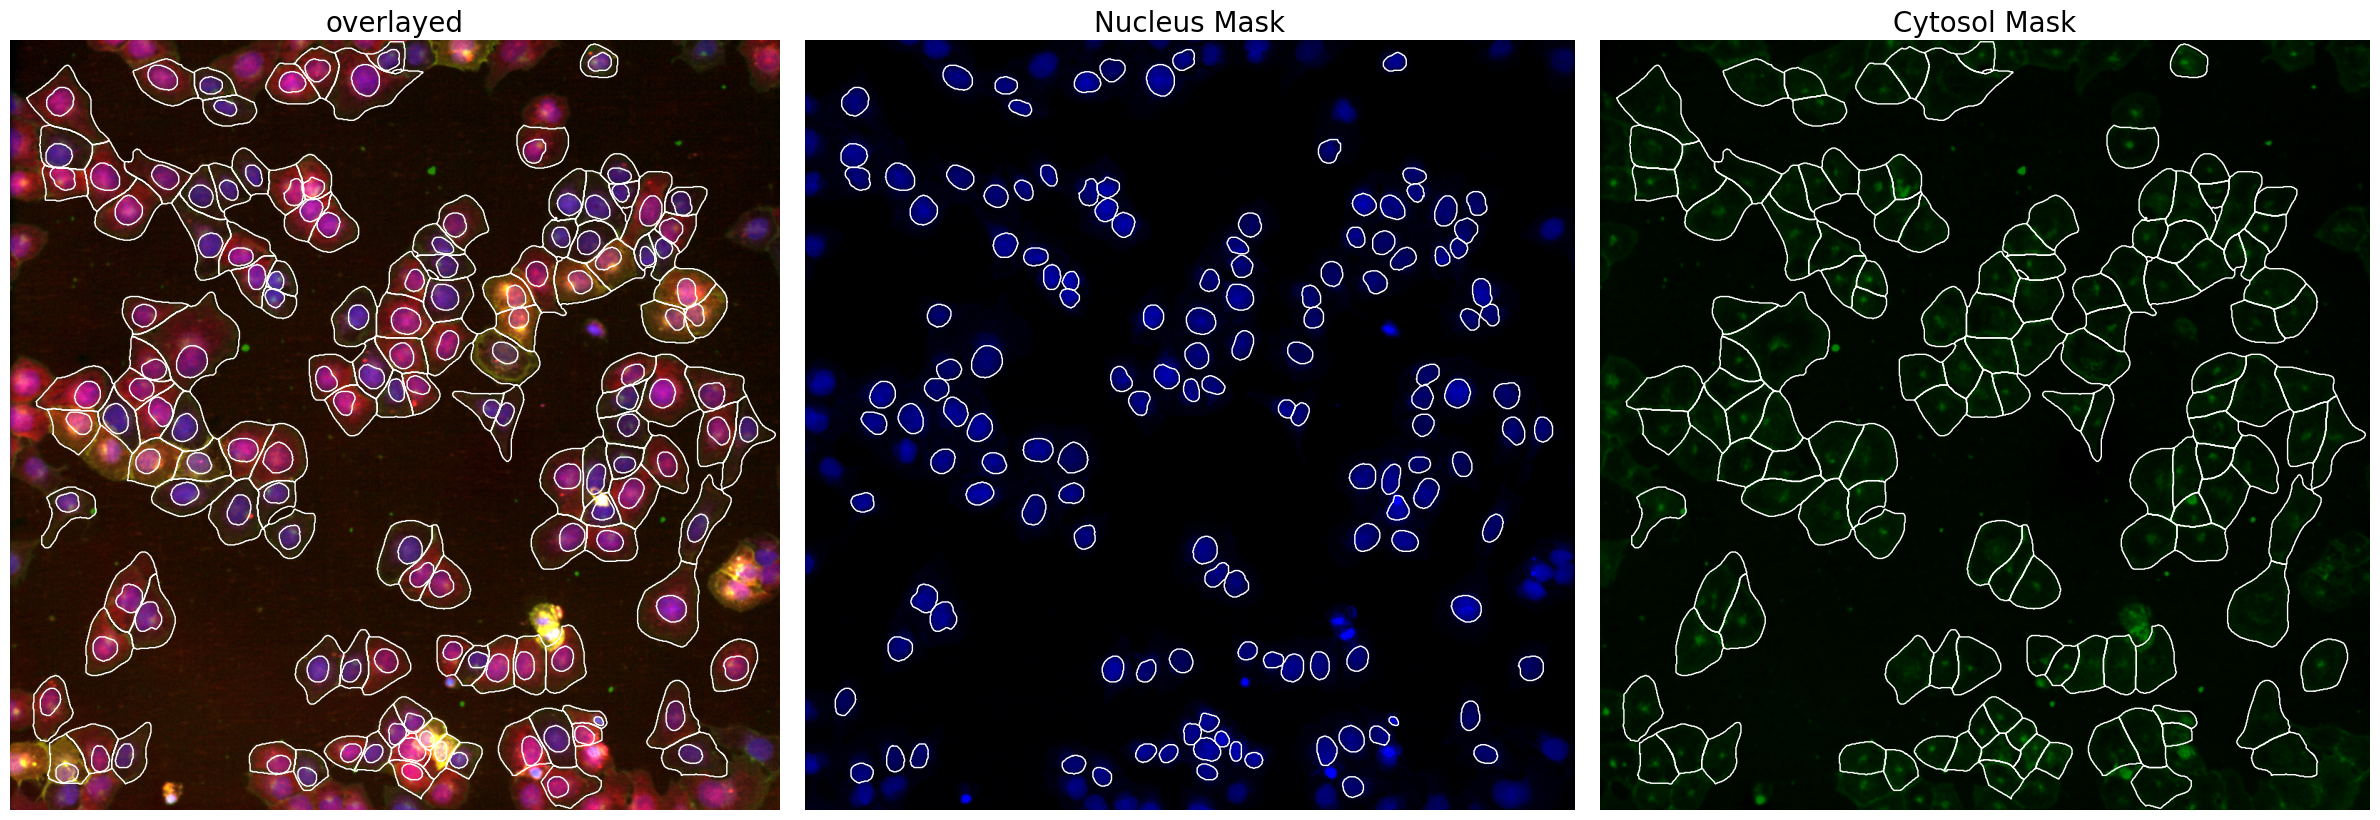

In [4]:
project.segment()
project.plot_segmentation_masks()

## Extract single cell-images

Now we are going to extract single-cell images using the same input segmentation mask, but each time modifying one of the configuration parameters of the Extraction workflow. 

We will look at the effects of the two most important parameters:
1. [`image_size`](#image-size)
2. [`normalize_output`](#choosing-normalization-method)
3. [`normalization_range`](#normalization-range)

And also investigate how we can fine-tune the normalization step to our specific use case. To improve computation we will only extract 2 cells for each configuration using the `partial` key during during the workflow call.

### Image Size

We will look at three different values for the parameter `image_size` and visualize the extracted single-cell images for each setting.

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


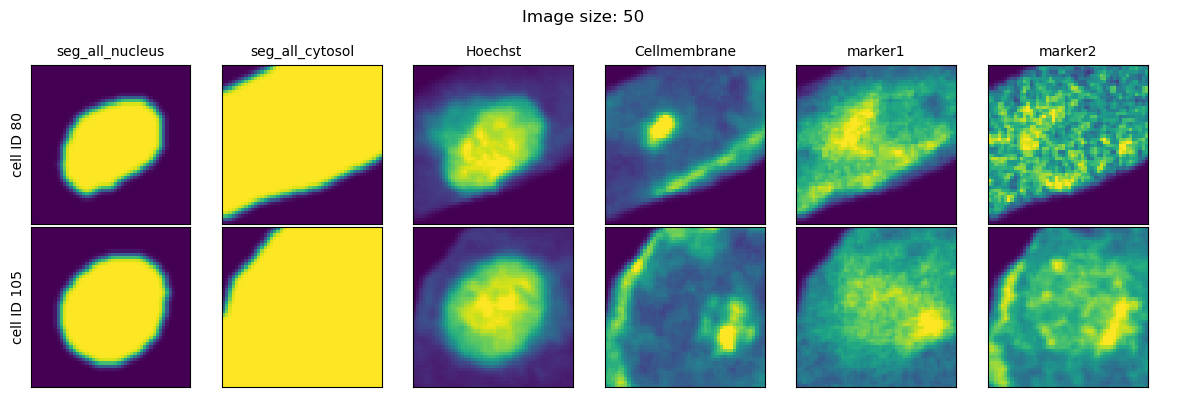

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


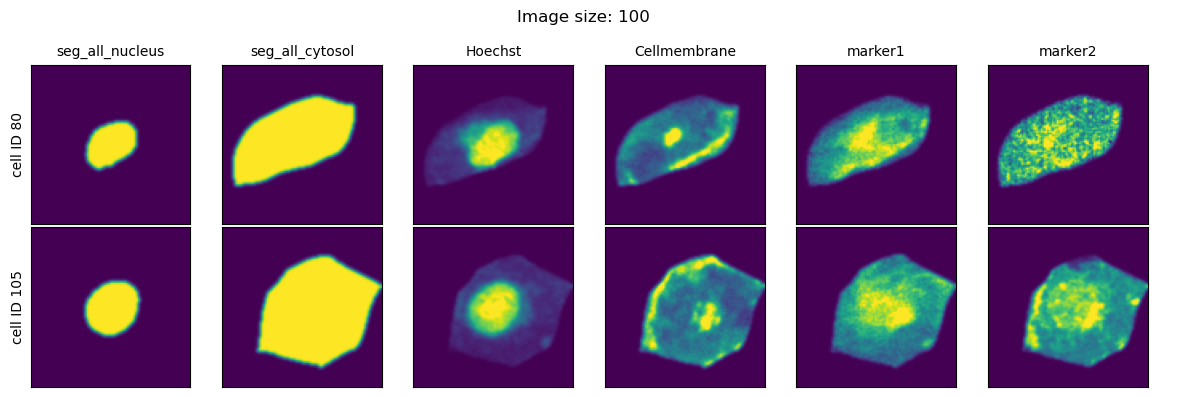

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s]


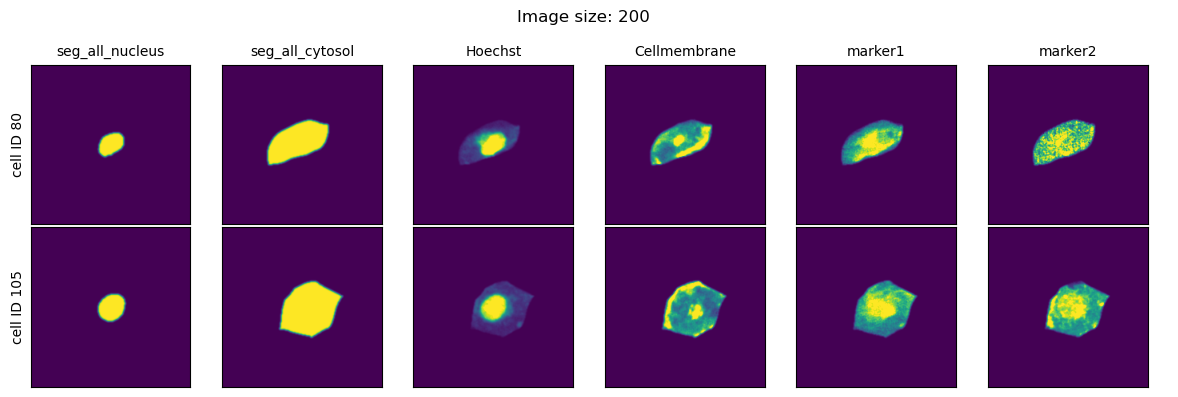

In [5]:
image_sizes = [50, 100, 200]
for image_size in image_sizes:
    project.config["HDF5CellExtraction"]["image_size"] = image_size
    project._update_extraction_f(HDF5CellExtraction)
    project.extract(partial=True, n_cells=2, seed = 92)

    fig = project.plot_single_cell_images(cell_ids=[80, 105], return_fig=True)
    fig.suptitle(f"Image size: {image_size}")
    fig.tight_layout()
    plt.show()

As we can see, image_size controls the size of the bounding box that is used to get the single-cell information from the dataset. Too small values for this parameter and the cells will be cutoff with information from their periphary missing. Too large values and our single-cell image datasets will largely consit of black pixels. 

This parameter will have to be configured based on the size of the cells you are imaging as well as the magnification at which the images are recorded.

## Image Normalization

All single-cell images generated by scPortrait are rescaled to the \([0, 1]\) range in preparation for downstream deep learning applications.

There are two approaches to how this normalization can occur:

1. Relative differences in the dataset are preserved:

   ```python
   img = img / max(dtype)
   ```

2. each cell is individually rescaled to

    ```python
    img = img - np.quantile(img, x) / np.quantile(img, y)
    ```

You are able to further customize method 2 by customizing the chosen quantiles for the normalization.

Which type of normalization method you should choose is highly dataset specific.

If you are working with cell selective stains (e.g. because you want to identifiy specific celltypes) then it is recommended to turn of the percentile normalization.

In contrast, if you are working with stains where you are only interested in the different spatial distribution of the marker of interest (e.g. because you are using an engineered cell line expressing a fluorescently tagged protein or general cell staining protocols like cell painting) then using the percentile normalization is recommended as it will help mitigate batch effects resulting from different concentrations of utilized cellstains. 

### Choosing normalization method

The normalization method can be chosen via the parameter `normalize_output`. This configures which of the two methods is selected.

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


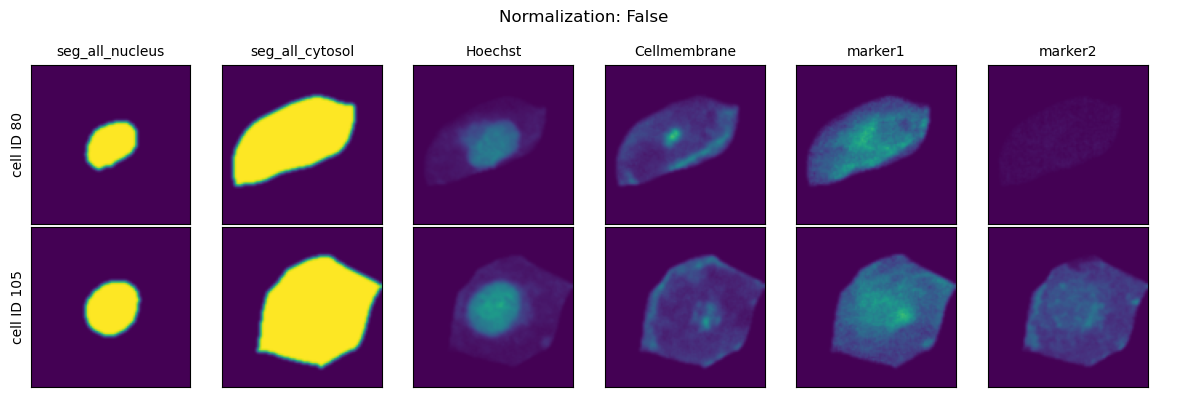

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]


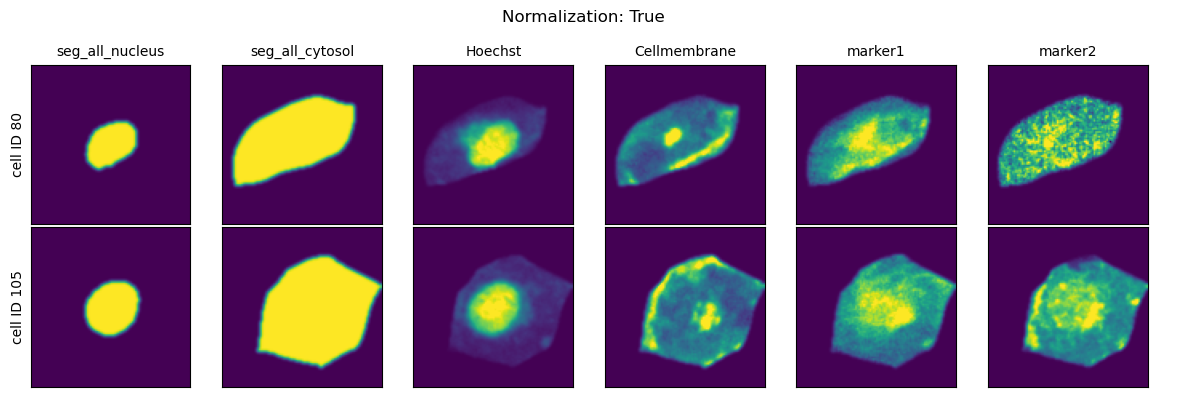

In [6]:
project.config["HDF5CellExtraction"]["image_size"] = 100 # set back to a good default value for our dataset

normalize_output = [False, True]
for normalization in normalize_output:
    project.config["HDF5CellExtraction"]["normalize_output"] = normalization
    project._update_extraction_f(HDF5CellExtraction)
    project.extract(partial=True, n_cells=2, seed = 92)

    fig = project.plot_single_cell_images(cell_ids=[80, 105], return_fig=True)
    fig.suptitle(f"Normalization: {normalization}")
    fig.tight_layout()
    plt.show()

### Normalization Range

When choosing the second method you can further specify how the per-cell normalization should be performed by providing quantiles to calculate the min and max values to rescale your data to via the parameter `normalization_range`.

This range per default is set to `(0.01, 0.99)`.

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 47.07it/s]


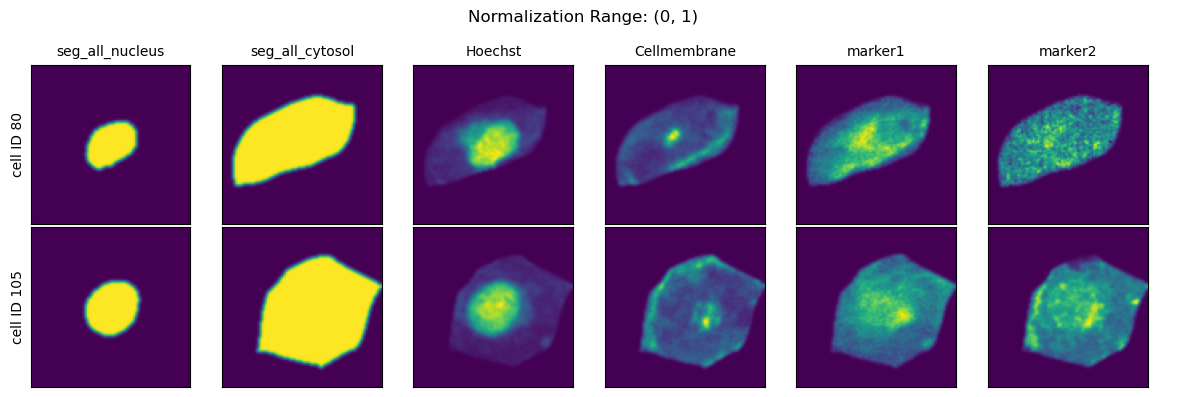

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


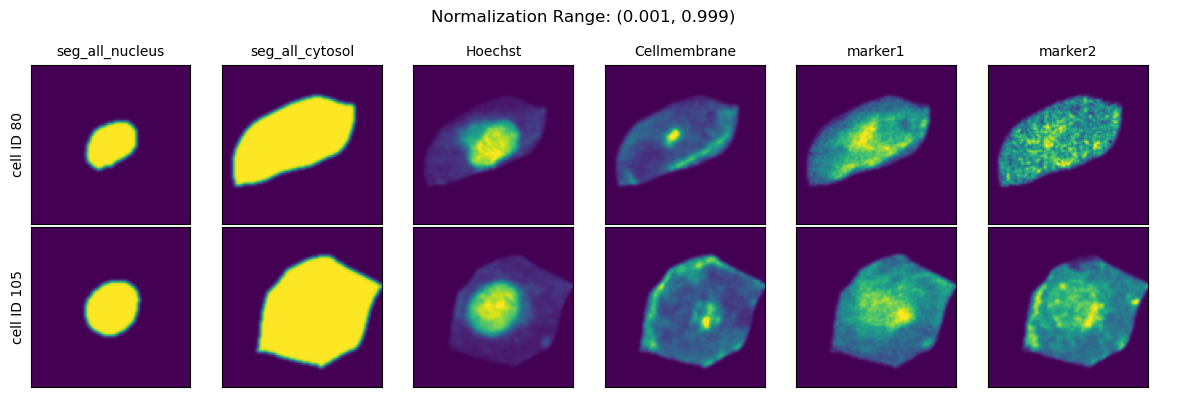

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 41.89it/s]


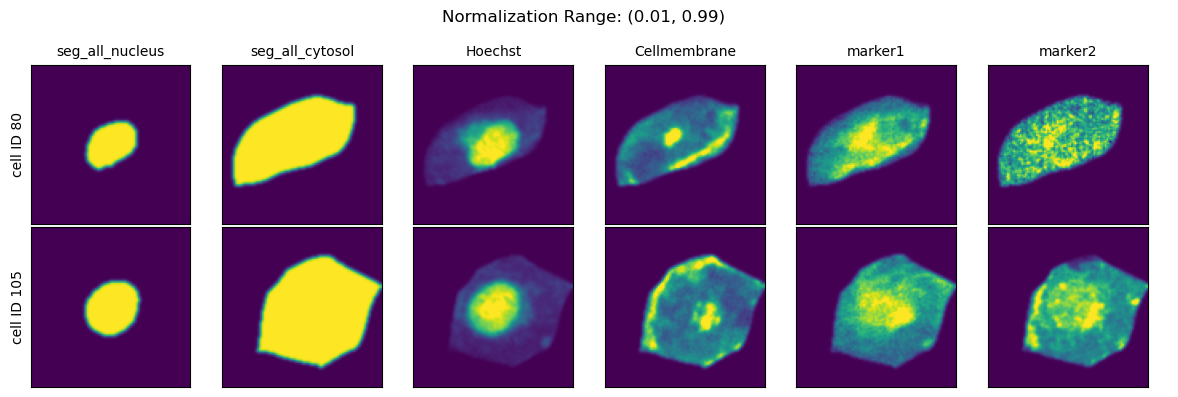

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]


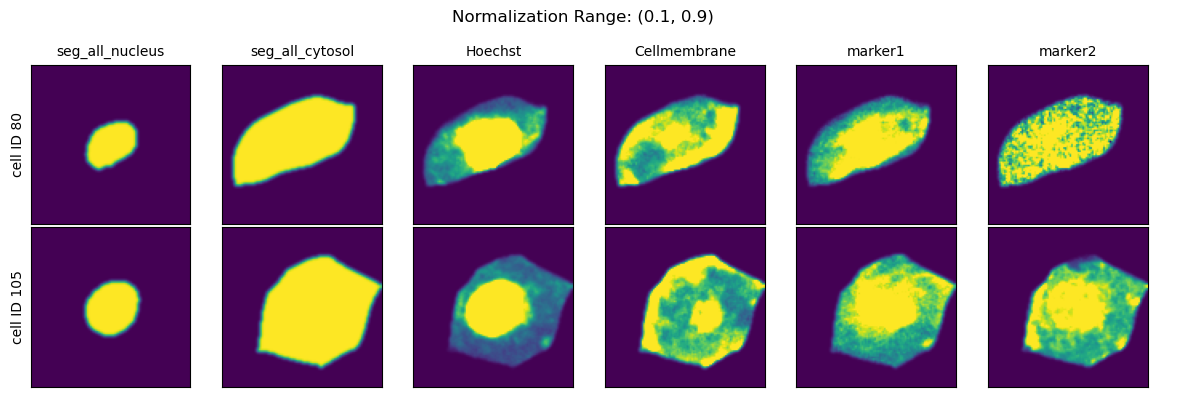

In [7]:
normalization_ranges = [(0, 1), (0.001, 0.999), (0.01, 0.99), (0.1, 0.9)]
for normalization_range in normalization_ranges:
    project.config["HDF5CellExtraction"]["normalization_range"] = normalization_range
    project._update_extraction_f(HDF5CellExtraction)
    project.extract(partial=True, n_cells=2, seed = 92)

    fig = project.plot_single_cell_images(cell_ids=[80, 105], return_fig=True)
    fig.suptitle(f"Normalization Range: {normalization_range}")
    fig.tight_layout()
    plt.show()